# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" />

> TL;DR: _Julia looks and feels a lot like Python, only much faster. It's dynamic, expressive, extensible, with batteries included, in particular for Data Science_.

This notebook is titled **Estimating the quarantine control parameter of COVID-19**.

## Running on Google Colab
### (Courtesy Julia Community for running Julia on Colab)
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

* _Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.4.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

## Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [1]:
versioninfo()

Julia Version 1.4.2
Commit 44fa15b150* (2020-05-23 18:35 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-1030NG7 CPU @ 1.10GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-8.0.1 (ORCJIT, goldmont)


# Estimating Quarantine Control Parameter

### Problem
The COVID-19 disease originated from Wuhan, China has resulted in a global pandemic, leading to almost 30.2 million confirmed cases in more than 200 countries worldwide. The governments of various countries took different approaches in tackling the COVID-19. For example, China decided to implement a travel ban from Wuhan, while other regions were relatively unaffected. However, China later, implemented nation-wide policies on travel ban. On the other hand, the US government took a relatively late decision on implementing policies against COVID-19, which resulted in an explosive growth of cases.

Some parts of the world including South Korea, Iran etc. saw an initial spike in the number of cases, but after a while, saw a drastic decrease in the number of cases. Singapore managed to maintain a low infection rate, but saw a second wave of infections.

Therefore, different local and nation governmental bodies took varying measures in tackling the COVID-19. Similarly, the behavior and intensity of COVID-19 varied with respect to geographical regions, appearing to be contained in some and exponentially increasing to catastrophic proportions in others like France and Italy.

Given this situation, there is a dire need to utilise the available data to compare the quarantine control policies implemented by different countries to tackle the COVID-19 spread. From the results, the researchers will not only be able to learn which policies are the most effective in curtailing the infection, but also prepare for any future epidemological disease because the world as it stands is really weak to pandemic causing, infectious diseases.

### Innovation
The existing models analyze the role of specific policies, e.g: the travel ban imposed in Wuhan, China, using either parameters derived from previous models of SARS viruses and not derived from the COVID-19 itself. 

Usually, the COVID-19 models estimating quarantine control parameter are data-driven, and hence, applicable only to the geographical region the data is derived from. They cannot be properly generalised, and often require parameter tuning differently for different regions.

Here, we use a novel method to estimate quarantine control parameter, **Scientific Machine Learning** which is a blend of scientific computing and machine learning. 
In traditional machine learning, the focus is on developing non-mechanistic models which are data-driven and require minimal prior assumptions. On the other hand, scientific computing uses prior scientific knowledge to develop mechanistic models usually based on first-principles based differential equations [1](#1--http://www.stochasticlifestyle.com/the-essential-tools-of-scientific-machine-learning-scientific-ml/). There are advantages and downsides to both approaches for modelling.

Recently, a new trend has emerged to utilize the advantages of both modelling methods, which is intended to be the best of both worlds, reducing the need of amount of data as well as prior assumptions required. In this internship project, we are using exactly the scientific machine learning to develop a mixed first principles based model with a flavor of data-driven module.

Using this trend, we have developed a generalised model that is independent to the geographical region and most importantly, based on the data provided, adapts to the region without any manual parameter tuning.

### Data Source
Main data source for developing and validating this technique is from John Hopkins University [2](#2--https://github.com/CSSEGISandData/COVID-19). The original data consists of daily report cases of all the countries. Since, we need to focus on a single country at a time, data is processed to retrieve and aggregate data from a single country.

In [ ]:
;git clone https://github.com/CSSEGISandData/COVID-19.git

In [5]:
using Pkg
Pkg.add("CSV")
Pkg.add("DataFrames")

  Resolving package versions...
######################################################################### 100.0%-=O=#  #   #    #                                                                                               37.6%    37.7%    39.2%             40.8%###############################   99.0%
######################################################################### 100.0%-#O#- #   #                                                                                    4.0%                       55.8%               65.2%             75.7%###                   77.1%83.7%##########           87.8%##########################################################      95.8%################################   99.7%
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Project.toml`
  [336ed68f] + CSV v0.7.7
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Manifest.toml`
  [79e6a3ab] ↑ Adapt v2.0.2 ⇒ v2.1.0
  [bf4720bc] - A

In [1]:
using CSV
using DataFrames

In [82]:
DATA_BASE_DIR = "COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

CONFIRMED_CSV = CSV.File(DATA_BASE_DIR * "time_series_covid19_confirmed_global.csv")
DEATHS_CSV = CSV.File(DATA_BASE_DIR * "time_series_covid19_deaths_global.csv")
RECOVERED_CSV = CSV.File(DATA_BASE_DIR * "time_series_covid19_recovered_global.csv")

CONFIRMED_DF = DataFrame(CONFIRMED_CSV)
DEATHS_DF = DataFrame(DEATHS_CSV)
RECOVERED_DF = DataFrame(RECOVERED_CSV)

,Province/State,Country/Region,Lat,Long,1/22/20
,String?,String,Float64,Float64,Int64
1,missing,Afghanistan,33.9391,67.71,0
2,missing,Albania,41.1533,20.1683,0
3,missing,Algeria,28.0339,1.6596,0
4,missing,Andorra,42.5063,1.5218,0
5,missing,Angola,-11.2027,17.8739,0
6,missing,Antigua and Barbuda,17.0608,-61.7964,0
7,missing,Argentina,-38.4161,-63.6167,0
8,missing,Armenia,40.0691,45.0382,0
9,Australian Capital Territory,Australia,-35.4735,149.012,0


In [83]:
COUNTRY = "Pakistan"

REGEX = r"^[4 5 6 7 8]/";

In [84]:
CONFIRMED_DF = CONFIRMED_DF[CONFIRMED_DF."Country/Region" .== COUNTRY, :]
CONFIRMED_DF = CONFIRMED_DF[!, REGEX]

DEATHS_DF = DEATHS_DF[DEATHS_DF."Country/Region" .== COUNTRY, :]
DEATHS_DF = DEATHS_DF[!, REGEX]

RECOVERED_DF = RECOVERED_DF[RECOVERED_DF."Country/Region" .== COUNTRY, :]
RECOVERED_DF = RECOVERED_DF[!, REGEX]

,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,125,126,131,211,259,429,467,572,727,762


In [85]:
Confirmed = sum.(eachcol(CONFIRMED_DF))'
Dead = sum.(eachcol(DEATHS_DF))'
Recovered = sum.(eachcol(RECOVERED_DF))'

# At any time point, confirmed people are sum of Infected, Recovered & Dead cases.
Infected = Confirmed - Recovered - Dead

# Confirming that the data is in confirmed shape
@assert length(Dead) == length(Confirmed) == length(Recovered)

data_length = length(Confirmed)

153

### First Principles based QSIR Model
There is a famous classic model for epidemological diseases, known as **SIR** model. In SIR model, we have a sucesptible population represented by **S**. This susceptible population can be infected with an infection rate **β** and converted into infected population represented **I**. Some people in the infected population recover or unfortunately die with a transition rate of **γ**. Both the recovered population and dead population is represented by **R**.

Both the infection rate **β** and the recovery/death rate (henceforth, referred to as only recovery rate) **γ** are constants and therefore, do not encode any information about policies that change with respect to time. This SIR based modelling, is therefore, insufficient to determine the effectiveness of quarantine control policies.

Hence, we use an alternative model known as **QSIR** model. Here, we introduce a time dependent variable Q(t) as estimated by a neural network that utilises the available data to decompose the effects and information about the quarantine control policies.

The model implies that in addition to some infected population **I** transitioning to recovered population **R** with a constant rate **γ**, some of the infected population will also be quarantined represented by **T** with a time varying parameter **Q(t)**. From the quarantined population **T**, transition will occur to the recovered population with a constant parameter **δ**. Hence, now, we have three constant parameters and one time varying parameter:
* β ---- Infection Rate 
* γ ---- Recovery Rate from Infection
* Q(t) - Quarantine Rate
* δ ---- Recovery Rate from Quarantined

![QSIR Model](Assets/QSIR-model.png)

One thing to notice is that our effective reproduction number also changes from
![Rt](Assets/Rt.png)
<p style="text-align: center;">to</p>

![Cp](Assets/Cp.png)

In [86]:
Recovered_Total = Recovered + Dead

1×153 LinearAlgebra.Adjoint{Int64,Array{Int64,1}}:
 159  166  172  258  312  486  528  637  …  286220  286624  286835  286976

### Time Varying parameter Q(t) estimation using NN

Universal Approximation Theorem implies that the neural networks can compute any function at all [3](#3--http://neuralnetworksanddeeplearning.com/chap4.html). No matter the function, there is guaranteed to be a neural network so that for every input x, the value f(x) is equal (or some approximation) to the output from the network. This property holds even if we restrict the neural network to a single hidden layer making even simple architectures very powerful.

We are going to use this ability of neural networks to estimate the time varying parameter Q(t). As we know even single hidden layer architectures hold this property, hence, our architecture is going to be really simple as well. Also, we are going to use ReLU activation function since it is known to be effective in approximating non-linear functions with a finite number of parameters [4](#4--Improving-deep-neural-networks-for-LVCSR-using-rectified-linear-units-and-dropout).

![NN-Architecture](Assets/Architecture.png)

In [ ]:
]add Flux

In [ ]:
using Flux

In [87]:
arch = Chain(Dense(3, 10, relu), Dense(10, 1))

Chain(Dense(3, 10, relu), Dense(10, 1))

### How to integrate first principles based modelling and NN?

This is where the Julia's tools come into play. Julia's various tools for scientific machine learning makes it a breeze to integrate and develop mixed first principles and data-driven models. In this scenario we are going to use Flux.jl to build our neural network and Differential Equations.jl to build our first principles physics based models. 

In [ ]:
]add DifferentialEquations DiffEqFlux

In [8]:
using DifferentialEquations
using DiffEqFlux

In [88]:
# Parameters for time varying Q(t) from neural network
p1, rest = Flux.destructure(arch)

# Parameters from the SIR: β, γ and δ
p2 = Float64[0.20, 0.01, 0.012]

# Combine both sets of parameters
p3 = [p1; p2]

# Flux Wrapper
params = Flux.params(p3)

length(p3) # We have 54 parameters that we can tune.

54

In [89]:
# Population of Paksitan which is 212.2 million
N = 212200000.0

function QSIR(du, u, p, t)
  β = abs(p[52])
  γ = abs(p[53])
  δ = abs(p[54])

  S = u[1]
  I = u[2]
  R = u[3]  
  T = u[4]

  u_t = [S; I; R]
  NN = abs(rest(p[1:51])(u_t)[1]) # Reconstruct our neural network

  du[1] = -β * S * I / N
  du[2] = (β * S * I / N) - (γ * I + I * NN / N)
  du[3] = γ * I + δ * T
  du[4] = NN * I / N - δ * T
end

u0 = Float64[N, Infected[1], Recovered_Total[1], 10]
tspan = (0.0, data_length)

prob = ODEProblem(QSIR, u0, tspan, p3)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 153.0)
u0: [2.122e8, 2262.0, 159.0, 10.0]

In [90]:
t = range(tspan[1], tspan[2], length=data_length)

solver = Tsit5()

Tsit5()

### What do differential equations have to do with machine learning!?

Differential equations are a way to specify structural information with an arbitrary non-linear transform [5](#5--https://julialang.org/blog/2019/01/fluxdiffeq/#what_do_differential_equations_have_to_do_with_machine_learning).

That was the official version, now let us simplify it a bit. There are three ways to specify a non-linear transform:
* Direct Modelling - Writing the non-linear function using first principles physics based analytical approach.
* Machine Learning - Data-driven to fit to the data resulting in a non-linear function.
* Differential Equations - Combining direct modelling and machine learning to specify non-linear transform as an ODE problem.

Now, Julia has a lot of tools to write out those ODE problems and then solve them with a wide range solvers it has, for your every needs (Stochastic, Partial, Ordinary) etc.

In QSIR based modelling, the differential equations are very intuitive and easy to understand.
![ODE](Assets/QSIR.png)

### Loss function

We are still missing the most important component for our neural network which is the loss function. We are going to use this loss function from the paper [6]().
![Loss Function](Assets/Loss.png)

In [91]:
function predict()
  Array(concrete_solve(prob, solver, u0, p3, saveat=t))
end

function calc_loss()
  prediction = predict()
  sum(abs2, log.(abs.(Infected[1:end])) .- log.(abs.(prediction[2, :] .+ prediction[4, :]))) + (sum(abs2, log.(abs.(Recovered_Total[1:end])) .- log.(abs.(prediction[3, :]))))
end

calc_loss (generic function with 1 method)

### Training

Using ADAM optimiser, and using Plots.jl to display the results of our training.

In [ ]:
]add Plots

In [75]:
using Plots

In [92]:
Losses = []
βs = []
γs = []
P3 = []

callback = function()
    loss = calc_loss()    
    global Losses = append!(Losses, loss)
    global βs = append!(βs, p3[52])
    global γs = append!(γs, p3[53])
    global P3 = append!(P3, p3)
end

#23 (generic function with 1 method)

In [93]:
anime = Animation()
iterator = Iterators.repeated((), 100)
opt = ADAM(0.01)

callback();

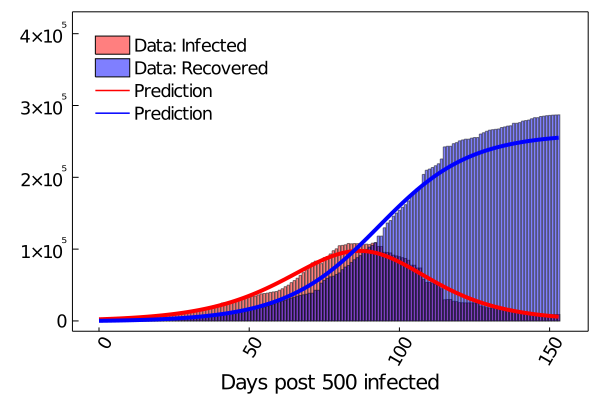

5.342221805573259

In [98]:
counter = 0
nE = 130

p3_loop = 0

for i = 1:nE
    Flux.train!(calc_loss, params, iterator, opt, cb = callback)
    
    plt = bar(Infected',alpha=0.5,label="Data: Infected",color="red")
    bar!(Recovered_Total',alpha=0.5,xrotation=60,label="Data: Recovered", color="blue")
    
    loss = findmin(Losses)
    
    idx = loss[2]
    idx_start = (idx - 1) * 54 + 1
    idx_end = idx * 54

    global p3_loop = P3[idx_start: idx_end]

    prediction = Array(concrete_solve(prob, Tsit5(), u0, p3_loop, saveat=t))

    plot!(plt, t, prediction[2, :] .+ prediction[4, :] , xaxis = "Days post 500 infected", label = "Prediction", legend = :topright, framestyle = :box, grid = :off, color = :red, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing, yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
    plot!(plt, t, prediction[3, :], ylims = (-0.05*maximum(Recovered_Total),1.5*maximum(Recovered_Total)), xaxis = "Days post 500 infected", label = "Prediction ", legend = :topleft, framestyle = :box, grid = :off, color = :blue, linewidth  = 4, foreground_color_legend = nothing, background_color_legend = nothing,  yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
    
    IJulia.clear_output(true)
    display(plt)
    display(loss[1])
end


### Visualisations

Let's visualize quarantine control parameter and try to validate it using real life implemented policies.

In [100]:
]add LaTeXStrings

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


Fetching: [========================================>]  100.0 %Fetching: [================================>        ]  80.0 %

  Resolving package versions...
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Project.toml`
  [b964fa9f] + LaTeXStrings v1.1.0
   Updating `~/Desktop/Projects/Research/TUKL Internship/Quarantine-Control-Estimation/Manifest.toml`
 [no changes]


In [101]:
using LaTeXStrings

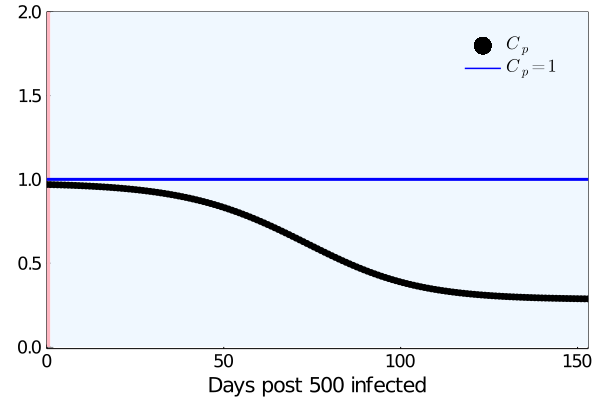

In [115]:
prediction = Array(concrete_solve(prob,Tsit5(),u0,p3_loop,saveat=t))

S_NN_all_loss = prediction[1, :]
I_NN_all_loss = prediction[2, :]
R_NN_all_loss = prediction[3, :]
T_NN_all_loss = prediction[4, :]

 Q_parameter = zeros(Float64, length(S_NN_all_loss), 1)

for i = 1:length(S_NN_all_loss)
  Q_parameter[i] = abs(rest(p3_loop[1:51])([S_NN_all_loss[i],I_NN_all_loss[i], R_NN_all_loss[i]])[1])
end

#Reproduction number
Reff = abs(p3_loop[52]) ./ (abs(p3_loop[53]) .+ abs(p3_loop[54]) .+ Q_parameter/u0[1])
if minimum(Reff) >1
 Transition = datasize + 5
else
Transition = findall(x -> x <1, Reff)[1]
end



Q_China = ((Q_parameter[30] - Q_parameter[1]) /u0[1])

plot([0, Transition[1]], [80, 80],fill=(0,:lightpink), markeralpha=0, label = "")
plot!([Transition[1], data_length], [80, 80],fill=(0,:aliceblue), markeralpha=0, label = "")
scatter!(t[1:end], Reff[1:end], xlims = (0, data_length), ylims = (-0.01, 2), xlabel = "Days post 500 infected", label = L"C_{p}", legend = :topright, color = :black, framestyle = :box, grid =:off, foreground_color_legend = nothing, background_color_legend = nothing, yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 12)
f(x) = 1
plot!(f, xlims = (0,data_length), color = :blue, linewidth = 3, label = L"C_{p} = 1")


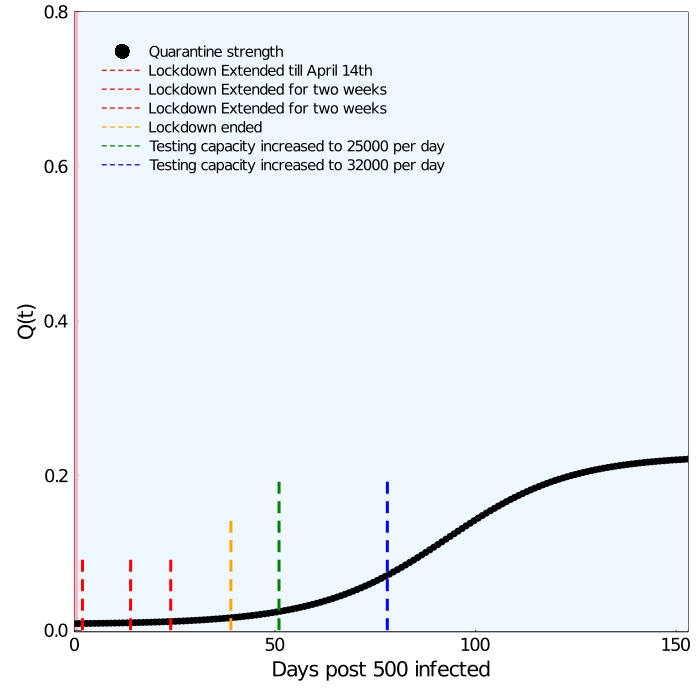

In [137]:
plot([0, Transition[1]], [80, 80], fill=(0,:lightpink), markeralpha=0, label = "", size=(700, 700))
plot!([Transition[1], data_length], [80, 80],fill=(0,:aliceblue), markeralpha=0, label = "")
scatter!(t,Q_parameter/u0[1], xlims = (0, data_length), ylims = (-0.002,0.8), xlabel = "Days post 500 infected", ylabel = "Q(t)", label = "Quarantine strength",color = :black, framestyle = :box, grid =:off, legend = :topleft, foreground_color_legend = nothing, background_color_legend = nothing,  yguidefontsize = 14, xguidefontsize = 14,  xtickfont = font(12, "TimesNewRoman"), ytickfont = font(12, "TimesNewRoman"), legendfontsize = 10)

plot!([2-0.01,2+0.01],[0.0, 0.1],lw=3,color=:red,label="Lockdown Extended till April 14th",linestyle = :dash)
plot!([14-0.01,14+0.01],[0.0, 0.1],lw=3,color=:red,label="Lockdown Extended for two weeks",linestyle = :dash)
plot!([24-0.01,24+0.01],[0.0, 0.1],lw=3,color=:red,label="Lockdown Extended for two weeks",linestyle = :dash)
plot!([39-0.01,39+0.01],[0.0, 0.15],lw=3,color=:orange,label="Lockdown ended",linestyle = :dash)
plot!([51-0.01,51+0.01],[0.0, 0.2],lw=3,color=:green,label="Testing capacity increased to 25000 per day",linestyle = :dash)
plot!([78-0.01,78+0.01],[0.0, 0.2],lw=3,color=:blue,label="Testing capacity increased to 32000 per day",linestyle = :dash)


# References:
### 1- http://www.stochasticlifestyle.com/the-essential-tools-of-scientific-machine-learning-scientific-ml/

Personal blog of Dr. Chris Rackaukas, Assistant Professor Mathematics at MIT.


### 2- https://github.com/CSSEGISandData/COVID-19

Data Centre operated by John Hopkins University.

### 3- http://neuralnetworksanddeeplearning.com/chap4.html

Chapter 4, Neural Networks and Deep Learning by author Michael Nielsen/Dec 2019.

### 4- Improving deep neural networks for LVCSR using rectified linear units and dropout

Dahl, G. E, Sainath, T. N, & Hinton, G. E. (2013) Improving deep neural networks for LVCSR
using rectified linear units and dropout. IEEE Acoustics, Speech and Signal Processing, 8609-
8613

### 5- https://julialang.org/blog/2019/01/fluxdiffeq/#what_do_differential_equations_have_to_do_with_machine_learning

DiffEqFlux.jl official documentaiton